In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import choice

import gzip
import csv
import json
import pandas as pd

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import re

from tqdm import tqdm_notebook as tqdm

import pickle

from os import mkdir 
from shutil import move

In [2]:
#adding this to avoid memory errors
%env JOBLIB_TEMP_FOLDER=/tmp

from tqdm import tqdm_notebook as tqdm

from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from pymystem3 import Mystem
import re

from nltk.stem import WordNetLemmatizer

from time import time

env: JOBLIB_TEMP_FOLDER=/tmp


C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ruslan_Golubev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ruslan_Golubev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ruslan_Golubev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk import word_tokenize, pos_tag

from nltk.stem.porter import PorterStemmer

In [10]:
def delete_non_letters(words):
    new_words = []
    for word in words:
        new_word = "".join(c for c in word if c.isalpha())
        if new_word != '':
            new_words.append(new_word)
    return new_words

def delete_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in stopwords.words('russian'):
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def normalize(text, tokenized=False, del_stopwords=False):
    if not tokenized:
        text = nltk.word_tokenize(text)
    
    text = delete_non_letters(text)
    if del_stopwords:
        text = delete_stopwords(text)
        
    text = to_lowercase(text)
    
    text = [word for word in text if len(word) > 1]
    return text


# Data loading

In [5]:
data_full = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\VK_EPAM_TA_SEARCH\text_3m.csv.gz')

Всего пока имеем 20499 постов.

In [6]:
len(list(data_full['text']))

20499

In [8]:
corpus = list(data_full['text'])
corpus[:5]

['наш с каждым днём всё более гуманный суд пришёл за гей-пабликами - как тут не подписаться.\n\n(а также прекрасное обращение "уважаемые солнышки", надо запомнить)',
 'Ух, ты... Common practice...\n\n In e-group on Monday October 15, 2019 we took the decision to enable a "job family country-of-residence block" for team members who have access to customer data. This is at the expressed concern of several enterprise customers, and also what is becoming a common practice in our industry in the current geopolitical climate.\n\nThe countries involved are:\n\nChina\nRussia',
 'А давайте тот же опрос, вид сбоку.',
 'опрос идеологический',
 'Аэропорт Лаппенранты летает только в аэропорта на букву Б. Поэтому Афины оттуда исключили, как расово-неверный маршрут.']

In [11]:
text_lens = []
text_proc = []
for sent in corpus:
    tok_sent = nltk.word_tokenize(sent)
    tok_sent = normalize(tok_sent, tokenized=True)
    text_lens.append(len(tok_sent))
    text_proc.append(tok_sent)

И выведем гистограмму длинн постов.

<function matplotlib.pyplot.show(*args, **kw)>

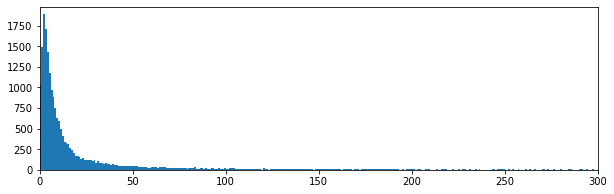

In [12]:
fig = plt.figure(figsize=(10, 3))
ax=fig.add_subplot(111)
plt.hist(text_lens, bins=[i  for i in range(int(50000/100))])
ax.set_xlim(xmin=0.0, xmax=300)
plt.show

In [13]:
mask = np.array(text_lens) < 25

In [14]:
short_texts = []
long_texts = []
for i in range(len(mask)):
    if mask[i]:
        short_texts.append(text_proc[i])
    else:
        long_texts.append(text_proc[i])

In [15]:
len(long_texts)

4490

In [16]:
len(short_texts)

16009

Поделим на трейн и тест наш оригинальный корпус.

In [19]:
train, test = train_test_split(corpus, test_size = 0.1, random_state = 666)

In [20]:
extra_stopwords = ['China', 'Common', 'In', 'Monday', 'October', 'Russia', 'The', 'This', 'access', 'also', 'becoming', 'block', 'climate', 'common', 'concern', 'country', 'country-of-residence', 'current', 'customer', 'data', 'decision', 'e-group', 'enable', 'enterprise', 'expressed', 'family', 'geopolitical', 'industry', 'involved', 'job', 'member', 'practice', 'several', 'team', 'took', 'Ух','arent', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wa', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve', 'хотел',"c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]
stopwords=set(nltk_stopwords.words('english') + nltk_stopwords.words('russian') + extra_stopwords)

In [45]:
#tokenzer for vectorizer
def delete_non_letters(words):
    new_words = []
    words = words.split(' ')
    for word in words:
        new_word = "".join(c for c in word if c.isalpha())
        if new_word != '':
            new_words.append(new_word)
    new_words = ' '.join(new_words)
    return new_words

def tokenize(sent):
    
    sent = sent.lower()
    sent = re.sub(r'\d+', '', sent)
    sent = delete_non_letters(sent)
    sent = nltk.word_tokenize(sent)
    
    return sent
    

def tf_idf(docs):
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords, smooth_idf=False,  lowercase=False)
    tfidf.fit(docs)
    return tfidf

In [46]:
tf_idf = tf_idf(train)

In [47]:
idfs = tf_idf.idf_

In [51]:
lower_thresh = 2.
upper_thresh = 7.
not_often = idfs > lower_thresh
not_rare = idfs < upper_thresh

mask = not_often * not_rare

good_words = np.array(tf_idf.get_feature_names())[mask]

In [52]:
cleaned = []
for word in good_words:
    word = re.sub("^(\d+\w*$|_+)", "", word)
    
    if len(word) == 0:
        continue
    cleaned.append(word)
print("Len of original vocabulary: %d\nAfter filtering: %d"%(idfs.shape[0], len(cleaned)))

Len of original vocabulary: 110476
After filtering: 720


In [54]:
#stemmin russian words and ignorin english
m = Mystem()
stemmed = set()
voc_len = len(cleaned)
for i in tqdm(range(voc_len)):
    word = cleaned.pop()
    stemmed_word = m.lemmatize(word)[0]
    stemmed.add(stemmed_word)
    
stemmed = list(stemmed)
print('After stemming: %d'%(len(stemmed)))


After stemming: 485


In [63]:
voc = {word : i for i,word in enumerate(stemmed)}

count_vect = CountVectorizer(tokenizer=tokenize,
                             stop_words=stopwords,
                             vocabulary=voc)

dataset = count_vect.fit_transform(train)

In [64]:
dataset

<18449x485 sparse matrix of type '<class 'numpy.int64'>'
	with 24799 stored elements in Compressed Sparse Row format>

In [65]:
lda = LDA(n_components=10, learning_method="batch", max_iter=30, random_state=0)
lda.fit(dataset)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [66]:
document_topics = lda.transform(dataset)

In [70]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 485)


In [73]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(count_vect.get_feature_names())

In [74]:
import mglearn

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [76]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
момент        вчера         фото          интересно     завтра        
важно         ребята        дома          осень         пусть         
цель          опыт          круто         скоро         история       
список        както         ко            метро         точно         
прямо         читать        репост        питер         привет        
мама          гдето         месяц         участие       наверное      
необходимо    го            сайт          проект        среди         
интервью      какойто       спб           настроение    рад           
план          помощь        курс          санктпетербургвместо        
столько       количество    игра          активный      наконецто     


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
чтот

In [58]:
s = np.argsort(document_topics[:, 9])[::-1]

In [59]:
s

array([ 3268, 15484, 17900, ..., 18309,  5779, 17810], dtype=int64)

In [68]:
train[17900]

'Я принял участие в голосовании «Лучший книжный магазин Москвы – 2019: выбор активных граждан» в проекте «Активный гражданин» и получил 20 баллов'

In [70]:
train[3268]

'Я принялa участие в голосовании «Лучший книжный магазин Москвы – 2019: выбор активных граждан» в проекте «Активный гражданин» и получилa 20 баллов'